In [1]:
import numpy  as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import datetime
from tensorflow.keras.callbacks import TensorBoard
import random
import tensorflow.keras.backend as K
import cv2
from tensorflow.keras.callbacks import Callback
from IPython.display import clear_output

In [2]:
image_size = (256, 256, 3)
epochs = 200
batch_size = 64
steps_per_epoch = np.floor((124704/batch_size))
val_steps = np.floor(7040/batch_size)
workers = 8
train_mask_dir   = 'data/train_mask'
train_raster_dir = 'data/train_raster'
val_mask_dir   = 'data/validation_mask'
val_raster_dir = 'data/validation_raster'
 
log_name = 'UNet_big_IoULoss_Oversampling_Vers.1_'

In [3]:
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

Data Augmentation

In [4]:
# code adapted from https://www.tensorflow.org/guide/data#consuming_python_generators

#normalize images
train_image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    )


train_mask_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    )

#train image data loader
train_image_generator = train_image_datagen.flow_from_directory(
    train_raster_dir,
    batch_size = batch_size,
    color_mode="rgb",
    class_mode=None,
    shuffle=True,
    seed = seed)

#train mask data loader
train_mask_generator = train_mask_datagen.flow_from_directory(
    train_mask_dir,
    batch_size = batch_size,
    color_mode="grayscale",
    class_mode=None,
    shuffle=True,
    seed = seed)

#the data loader have to be zipped to get corresponding mask to an image
train_generator = zip(train_image_generator, train_mask_generator)
#aus https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator


# https://www.tensorflow.org/guide/data#consuming_python_generators

#validation image data loader
val_image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
    )
#validation image data loader
val_mask_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    )

val_image_generator = val_image_datagen.flow_from_directory(
    val_raster_dir,
    batch_size = batch_size,
    color_mode="rgb",
    class_mode=None,
    seed = seed)

val_mask_generator = val_mask_datagen.flow_from_directory(
    val_mask_dir,
    batch_size = batch_size,
    color_mode="grayscale",
    class_mode=None,
    seed = seed)

val_generator = zip(val_image_generator, val_mask_generator)

Found 124672 images belonging to 2 classes.
Found 124672 images belonging to 2 classes.
Found 7040 images belonging to 2 classes.
Found 7040 images belonging to 2 classes.


In [5]:
#make the data loader to tf.data to be able to perform multiprocessing
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = tf.data.Dataset.from_generator(
    lambda: train_generator, 
    output_types=(tf.float32, tf.float32), 
    output_shapes=([batch_size,256,256,3], [batch_size,256,256,1])
)

#train_ds = train_ds.map(map_img, num_parallel_calls= workers).cache()
# #rain_ds = train_ds.batch(64).prefetch(AUTOTUNE) 
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)     
    
train_ds.element_spec

(TensorSpec(shape=(64, 256, 256, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(64, 256, 256, 1), dtype=tf.float32, name=None))

In [6]:
val_ds = tf.data.Dataset.from_generator(
    lambda: val_generator, 
    output_types=(tf.float32, tf.float32), 
    output_shapes=([batch_size,256,256,3], [batch_size,256,256,1])
)

#val_ds = val_ds.map(map_img)
# #val_ds = val_ds.batch(64)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)    


val_ds.element_spec

(TensorSpec(shape=(64, 256, 256, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(64, 256, 256, 1), dtype=tf.float32, name=None))

Loss Functions

In [7]:
#dice loss implementation adapted from https://www.kaggle.com/bigironsphere/loss-function-library-keras-pytorch#Dice-Loss
#@param targets the ground truth
#@param inputs the predicted segmentation
def DiceLoss(targets, inputs, smooth=1e-6):
    
    #flatten label and prediction tensors
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    
    intersection = K.sum(targets * inputs)
    dice = (2*intersection + smooth) / (K.sum(targets) + K.sum(inputs) + smooth)
    return 1 - dice


In [7]:
#IoU loss implementation adapted from https://www.kaggle.com/bigironsphere/loss-function-library-keras-pytorch#Dice-Loss
#@param targets the ground truth
#@param inputs the predicted segmentation
def IoULoss(targets, inputs, smooth=1e-6):

    #flatten label and prediction tensors
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    
    intersection = K.sum(targets * inputs)
    total = K.sum(targets) + K.sum(inputs)
    union = total - intersection
    
    IoU = (intersection + smooth) / (union + smooth)
    return 1- IoU

In [10]:
#IoU loss implementation adapted from https://www.kaggle.com/bigironsphere/loss-function-library-keras-pytorch#Dice-Loss
#@param targets the ground truth
#@param inputs the predicted segmentation
#@param alpha the hyperparameter
#@param beta the hyperparameter
def TverskyLoss(targets, inputs, alpha=0.7, beta=0.3, smooth=1e-6):
        
        #flatten label and prediction tensors
        inputs = K.flatten(inputs)
        targets = K.flatten(targets)
        
        #True Positives, False Positives & False Negatives
        TP = K.sum((inputs * targets))
        FP = K.sum(((1-targets) * inputs))
        FN = K.sum((targets * (1-inputs)))
       
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        
        return 1-Tversky

Metric

In [8]:
def IoUScore(targets, inputs, smooth=1e-6):

    #flatten label and prediction tensors
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    
    intersection = K.sum(targets * inputs)
    total = K.sum(targets) + K.sum(inputs)
    union = total - intersection
    
    IoU = (intersection + smooth) / (union + smooth)
    return IoU

In [9]:
def IoUScoreThreshold05(targets, inputs, smooth=1e-6, threshold=0.5):
    
    
    inputs = K.cast(K.greater(K.clip(inputs, 0, 1), threshold), K.floatx())
    #flatten label and prediction tensors
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    
    intersection = K.sum(targets * inputs)
    total = K.sum(targets) + K.sum(inputs)
    union = total - intersection
    
    IoU = (intersection + smooth) / (union + smooth)
    return IoU
 
# https://stackoverflow.com/questions/42606207/keras-custom-decision-threshold-for-precision-and-recall

In [14]:
# def IoUScoreThreshold08(targets, inputs, smooth=1e-6, threshold=0.8):
    
    
#     inputs = K.cast(K.greater(K.clip(inputs, 0, 1), threshold), K.floatx())
#     #flatten label and prediction tensors
#     inputs = K.flatten(inputs)
#     targets = K.flatten(targets)
    
#     intersection = K.sum(targets * inputs)
#     total = K.sum(targets) + K.sum(inputs)
#     union = total - intersection
    
#     IoU = (intersection + smooth) / (union + smooth)
#     return IoU

Model

In [10]:
#initializer to initialize the weights of the model 
initializer = tf.keras.initializers.HeNormal()


In [11]:
def down_block(x, filters, kernel_size=(3,3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, kernel_initializer=initializer, strides=strides, activation= "relu")(x)
    c = keras.layers.BatchNormalization()(c)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, kernel_initializer=initializer, strides=strides, activation= "relu")(c)
    c = keras.layers.BatchNormalization()(c)
    p = keras.layers.MaxPool2D((2,2), (2,2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3,3), padding="same", strides=1):
    us= keras.layers.UpSampling2D((2,2))(x)
    concat = keras.layers.Concatenate()([us,skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, kernel_initializer=initializer, strides=strides, activation= "relu")(concat)
    c = keras.layers.BatchNormalization()(c)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, kernel_initializer=initializer, strides=strides, activation= "relu")(c)
    c = keras.layers.BatchNormalization()(c)
    return c

def bottleneck(x, filters, kernel_size=(3,3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, kernel_initializer=initializer, strides=strides, activation= "relu")(x)
    c = keras.layers.BatchNormalization()(c)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, kernel_initializer=initializer, strides=strides, activation= "relu")(c)
    c = keras.layers.BatchNormalization()(c)
    return c

In [25]:
def UNet():
    #for the small model f=[16,32,64,128,256,512,1024]
    f=[32,64,128,256,512,1024,2048]
    inputs = keras.Input(image_size)
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #  256 -> 128
    c2, p2 = down_block(p1, f[1]) #  128 ->  64
    c3, p3 = down_block(p2, f[2]) #   64 ->  32
    c4, p4 = down_block(p3, f[3]) #   32 ->  16
    c5, p5 = down_block(p4, f[4]) #   16 ->   8
    c6, p6 = down_block(p5, f[5]) #    8 ->   4
    
    bn = bottleneck(p6, f[6])
    
    u1 = up_block(bn, c6, f[5])    #   4 ->   8
    u2 = up_block(u1, c5, f[4])    #   8 ->  16
    u3 = up_block(u2, c4, f[3])    #  16 ->  32
    u4 = up_block(u3, c3, f[2])    #  32 ->  64
    u5 = up_block(u4, c2, f[1])    #  64 -> 128
    u6 = up_block(u5, c1, f[0])    # 128 -> 256
       
    
    outputs = keras.layers.Conv2D(1, (1,1), padding="same", activation = "sigmoid")(u6)
    model = keras.models.Model(inputs, outputs)
    return model

In [26]:
model = UNet() 
model.compile(optimizer="nadam", loss=IoULoss, metrics=[IoUScore, IoUScoreThreshold05, tf.keras.metrics.MeanIoU(num_classes=2)])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_27 (Conv2D)              (None, 256, 256, 32) 896         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_26 (BatchNo (None, 256, 256, 32) 128         conv2d_27[0][0]                  
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 256, 256, 32) 9248        batch_normalization_26[0][0]     
____________________________________________________________________________________________

Callbacks

Tensorboard callback adappted from https://towardsdatascience.com/semantic-segmentation-visualization-of-learning-progress-by-tensorboard-7272fd5b6b50

In [14]:
#four pictuers used in Tensorboard 
X_tb = np.load('TensorboardImages/X.npy')
y_tb = np.load('TensorboardImages/y.npy') 

In [15]:
def display(display_list):
    figure = plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    #plt.show()
    return figure

In [16]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [17]:
def show_predictions(i):
    pred_mask = model.predict(X_tb[i].reshape(1,256,256,3))
    return(display([X_tb[i],y_tb[i],(pred_mask.reshape(256,256,1))]))

In [18]:
import io

def plot_to_image(figure):
  #"""Converts the matplotlib plot specified by 'figure' to a PNG image and returns it. The supplied figure is closed and inaccessible after this call."""
  # Save the plot to a PNG in memory.
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
  # Closing the figure prevents it from being displayed directly inside
  # the notebook.
    plt.close(figure)
    buf.seek(0)
  # Convert PNG buffer to TF image
    image = tf.image.decode_png(buf.getvalue(), channels=4)
  # Add the batch dimension
    image = tf.expand_dims(image, 0)
    return image

In [19]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        #clear_output(wait=True)
        figure0 = show_predictions(0)   
        with file_writer.as_default():
            tf.summary.image("Train1 img", plot_to_image(figure0), step=epoch+1)
            
        figure1 = show_predictions(1)  
        with file_writer.as_default():
            tf.summary.image("Train2 img", plot_to_image(figure1), step=epoch+1)
         
        figure2 = show_predictions(2)
        with file_writer.as_default():
            tf.summary.image("Val1 img", plot_to_image(figure2), step=epoch+1)
            
        figure3 = show_predictions(3)
        with file_writer.as_default():
            tf.summary.image("Val2 img", plot_to_image(figure3), step=epoch+1)

In [20]:
X = train_image_generator.next() 
y = train_mask_generator.next()

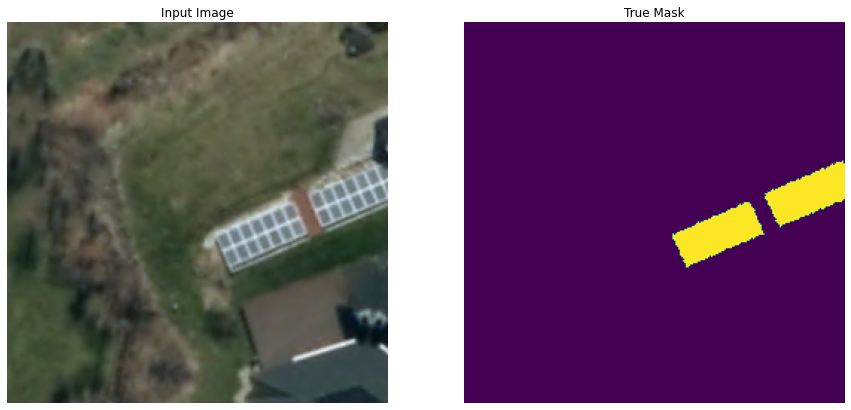

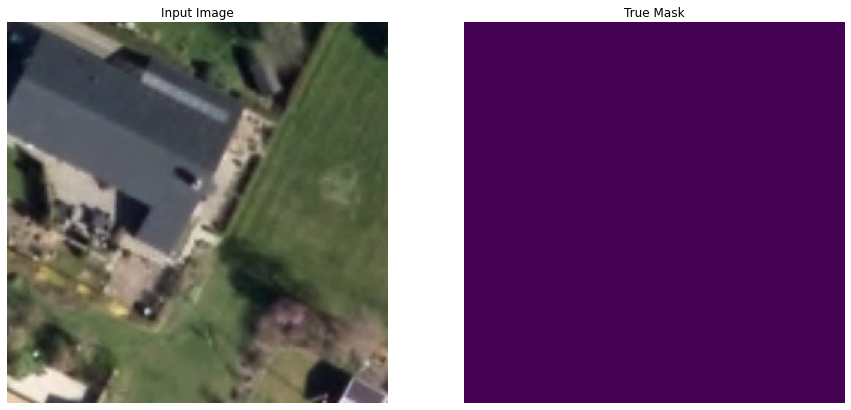

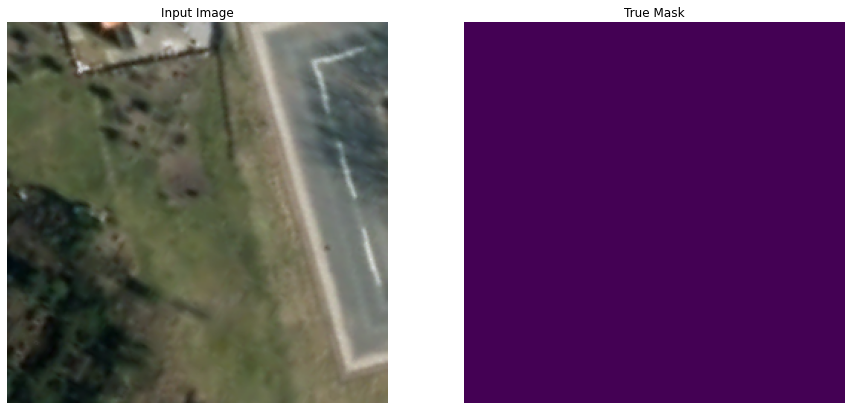

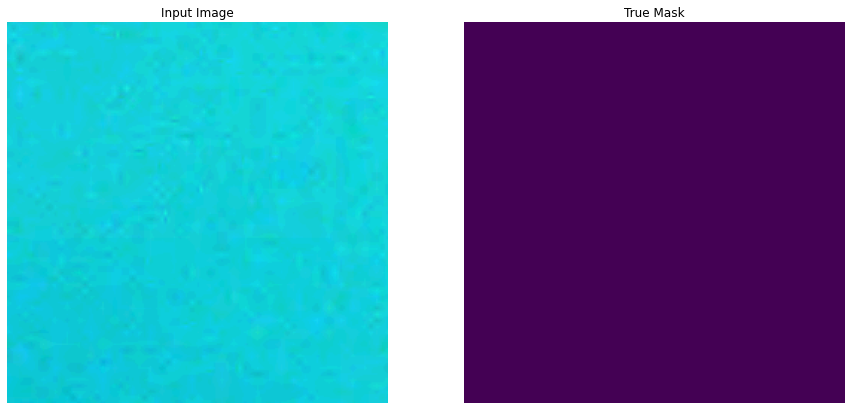

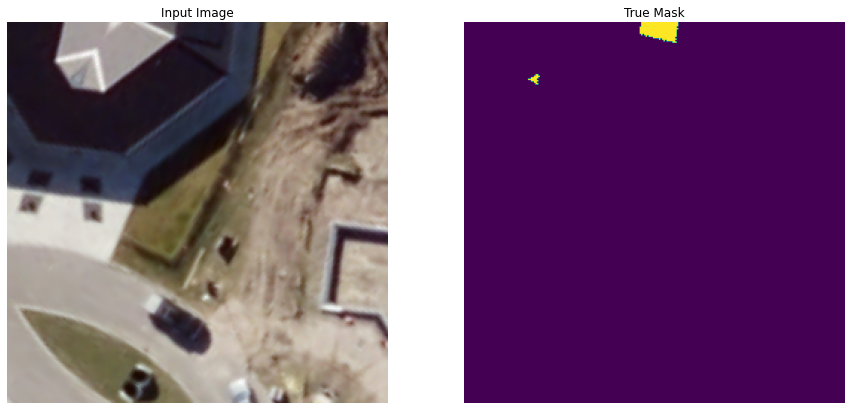

In [21]:
#visual inspectation of the data loader
for i in range(0,5):
    display([X[i],y[i]])

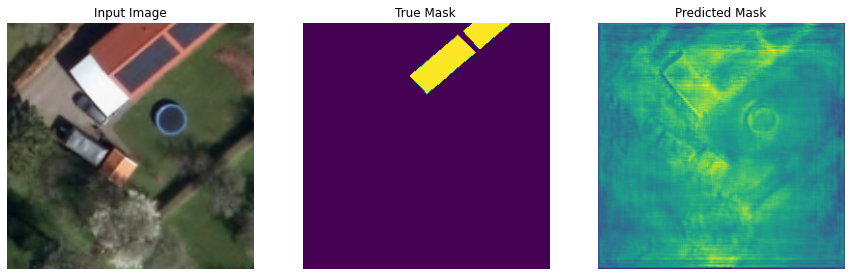

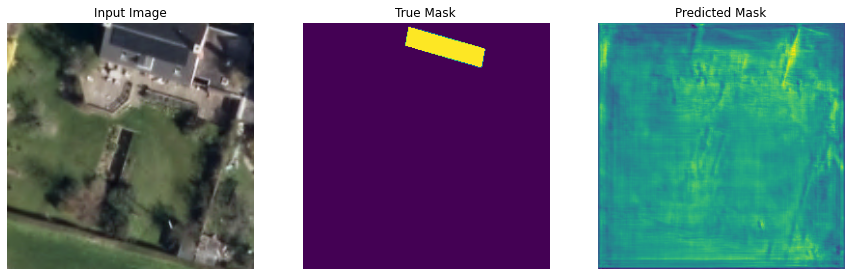

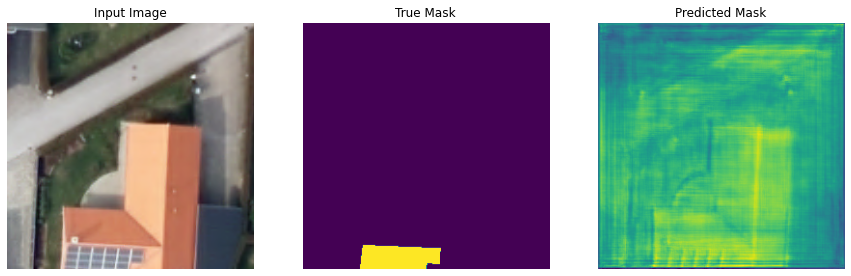

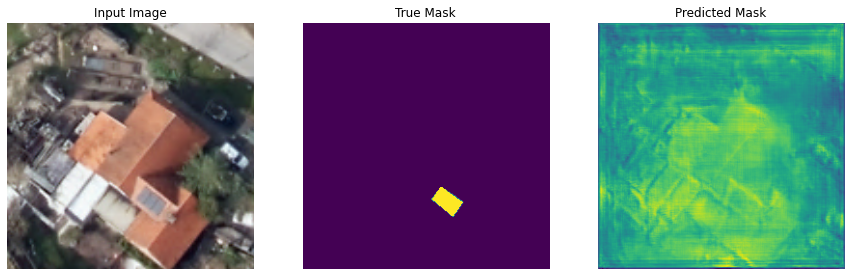

In [25]:
#prediction of the tensorboard images before training
show_predictions(0).show()
show_predictions(1).show()
show_predictions(2).show()
show_predictions(3).show()

In [27]:
#callback
log_dir = "runs/" + log_name + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer = tf.summary.create_file_writer(log_dir + "/image")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch = '500,520')

# early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, verbose=1, monitor="val_IoUScore", mode = 'max')
# reduceLR = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=15, min_lr=0.00001, verbose=1)
checkpoint = tf.keras.callbacks.ModelCheckpoint('checkpoint/' + log_name, verbose=1, 
                                                save_best_only=True, 
                                                save_weights_only=True, 
                                                monitor='val_mean_io_u', 
                                                mode='max')

In [28]:
callbacks = [
    checkpoint,
    tensorboard_callback, 
    DisplayCallback()
]

Training

In [29]:
#train the model
history_base = model.fit(train_ds,
          batch_size = batch_size,
          steps_per_epoch = steps_per_epoch,
          epochs=epochs,
          validation_data= val_ds, 
          validation_steps=val_steps,
          callbacks=callbacks,               
          use_multiprocessing=True,
          workers=workers
    )

# saving the history as numpy and the final model
np.save('history/' + log_name + '.npy',history_base.history)
model.save('model/' + log_name)

Epoch 1/200
1948/1948 [==============================] - 1174s 478ms/step - loss: 0.4731 - IoUScore: 0.5269 - IoUScoreThreshold05: 0.5534 - mean_io_u_1: 0.7614 - val_loss: 0.8528 - val_IoUScore: 0.1472 - val_IoUScoreThreshold05: 0.1475 - val_mean_io_u_1: 0.7137
Epoch 2/200
1948/1948 [==============================] - 919s 472ms/step - loss: 0.2248 - IoUScore: 0.7752 - IoUScoreThreshold05: 0.7754 - mean_io_u_1: 0.8914 - val_loss: 0.7816 - val_IoUScore: 0.2184 - val_IoUScoreThreshold05: 0.2188 - val_mean_io_u_1: 0.7781
Epoch 3/200
1948/1948 [==============================] - 920s 472ms/step - loss: 0.1383 - IoUScore: 0.8617 - IoUScoreThreshold05: 0.8618 - mean_io_u_1: 0.9327 - val_loss: 0.7937 - val_IoUScore: 0.2063 - val_IoUScoreThreshold05: 0.2155 - val_mean_io_u_1: 0.8211
Epoch 4/200
 702/1948 [=========>....................] - ETA: 9:33 - loss: 0.1214 - IoUScore: 0.8786 - IoUScoreThreshold05: 0.8786 - mean_io_u_1: 0.9406

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



1948/1948 [==============================] - 920s 472ms/step - loss: 0.0850 - IoUScore: 0.9150 - IoUScoreThreshold05: 0.9150 - mean_io_u_1: 0.9578 - val_loss: 0.8317 - val_IoUScore: 0.1683 - val_IoUScoreThreshold05: 0.4227 - val_mean_io_u_1: 0.8772
Epoch 10/200
1948/1948 [==============================] - 920s 472ms/step - loss: 0.0844 - IoUScore: 0.9156 - IoUScoreThreshold05: 0.9156 - mean_io_u_1: 0.9577 - val_loss: 0.7533 - val_IoUScore: 0.2467 - val_IoUScoreThreshold05: 0.4649 - val_mean_io_u_1: 0.9100
Epoch 11/200
 470/1948 [======>.......................] - ETA: 11:19 - loss: 0.0730 - IoUScore: 0.9270 - IoUScoreThreshold05: 0.9270 - mean_io_u_1: 0.9636

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



1948/1948 [==============================] - 920s 472ms/step - loss: 0.0680 - IoUScore: 0.9320 - IoUScoreThreshold05: 0.9320 - mean_io_u_1: 0.9659 - val_loss: 0.6973 - val_IoUScore: 0.3027 - val_IoUScoreThreshold05: 0.4118 - val_mean_io_u_1: 0.9186
Epoch 17/200
1948/1948 [==============================] - 919s 472ms/step - loss: 0.0644 - IoUScore: 0.9356 - IoUScoreThreshold05: 0.9357 - mean_io_u_1: 0.9677 - val_loss: 0.6740 - val_IoUScore: 0.3260 - val_IoUScoreThreshold05: 0.4896 - val_mean_io_u_1: 0.9108
Epoch 18/200
1948/1948 [==============================] - 931s 478ms/step - loss: 0.0604 - IoUScore: 0.9396 - IoUScoreThreshold05: 0.9396 - mean_io_u_1: 0.9693 - val_loss: 0.7191 - val_IoUScore: 0.2809 - val_IoUScoreThreshold05: 0.4810 - val_mean_io_u_1: 0.9069
Epoch 19/200
1948/1948 [==============================] - 926s 475ms/step - loss: 0.0675 - IoUScore: 0.9325 - IoUScoreThreshold05: 0.9325 - mean_io_u_1: 0.9662 - val_loss: 0.6671 - val_IoUScore: 0.3329 - val_IoUScoreThreshold05

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



1948/1948 [==============================] - 919s 472ms/step - loss: 0.0586 - IoUScore: 0.9414 - IoUScoreThreshold05: 0.9414 - mean_io_u_1: 0.9705 - val_loss: 0.6474 - val_IoUScore: 0.3526 - val_IoUScoreThreshold05: 0.3890 - val_mean_io_u_1: 0.8847
Epoch 23/200
1948/1948 [==============================] - 919s 472ms/step - loss: 0.0565 - IoUScore: 0.9435 - IoUScoreThreshold05: 0.9435 - mean_io_u_1: 0.9716 - val_loss: 0.7128 - val_IoUScore: 0.2872 - val_IoUScoreThreshold05: 0.5415 - val_mean_io_u_1: 0.9106
Epoch 24/200
1948/1948 [==============================] - 920s 472ms/step - loss: 0.0544 - IoUScore: 0.9456 - IoUScoreThreshold05: 0.9456 - mean_io_u_1: 0.9722 - val_loss: 0.6813 - val_IoUScore: 0.3187 - val_IoUScoreThreshold05: 0.5550 - val_mean_io_u_1: 0.9274
Epoch 25/200
1948/1948 [==============================] - 920s 472ms/step - loss: 0.0567 - IoUScore: 0.9433 - IoUScoreThreshold05: 0.9433 - mean_io_u_1: 0.9713 - val_loss: 0.6903 - val_IoUScore: 0.3097 - val_IoUScoreThreshold05

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



1948/1948 [==============================] - 920s 472ms/step - loss: 0.0491 - IoUScore: 0.9509 - IoUScoreThreshold05: 0.9509 - mean_io_u_1: 0.9749 - val_loss: 0.6805 - val_IoUScore: 0.3195 - val_IoUScoreThreshold05: 0.4466 - val_mean_io_u_1: 0.9092
Epoch 33/200
1948/1948 [==============================] - 920s 472ms/step - loss: 0.0483 - IoUScore: 0.9517 - IoUScoreThreshold05: 0.9518 - mean_io_u_1: 0.9754 - val_loss: 0.6745 - val_IoUScore: 0.3255 - val_IoUScoreThreshold05: 0.4982 - val_mean_io_u_1: 0.9336
Epoch 34/200
 559/1948 [=======>......................] - ETA: 10:37 - loss: 0.0466 - IoUScore: 0.9534 - IoUScoreThreshold05: 0.9534 - mean_io_u_1: 0.9761

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



1948/1948 [==============================] - 919s 472ms/step - loss: 0.0451 - IoUScore: 0.9549 - IoUScoreThreshold05: 0.9549 - mean_io_u_1: 0.9769 - val_loss: 0.7213 - val_IoUScore: 0.2787 - val_IoUScoreThreshold05: 0.4967 - val_mean_io_u_1: 0.9126
Epoch 40/200
1948/1948 [==============================] - 919s 472ms/step - loss: 0.0495 - IoUScore: 0.9505 - IoUScoreThreshold05: 0.9505 - mean_io_u_1: 0.9750 - val_loss: 0.6441 - val_IoUScore: 0.3559 - val_IoUScoreThreshold05: 0.5649 - val_mean_io_u_1: 0.9216
Epoch 41/200
 133/1948 [=>............................] - ETA: 13:52 - loss: 0.0429 - IoUScore: 0.9571 - IoUScoreThreshold05: 0.9571 - mean_io_u_1: 0.9779

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



1948/1948 [==============================] - 919s 472ms/step - loss: 0.0418 - IoUScore: 0.9582 - IoUScoreThreshold05: 0.9582 - mean_io_u_1: 0.9787 - val_loss: 0.7110 - val_IoUScore: 0.2890 - val_IoUScoreThreshold05: 0.5964 - val_mean_io_u_1: 0.9391
Epoch 47/200
1273/1948 [==================>...........] - ETA: 5:10 - loss: 0.0417 - IoUScore: 0.9583 - IoUScoreThreshold05: 0.9584 - mean_io_u_1: 0.9786

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



1948/1948 [==============================] - 919s 472ms/step - loss: 0.0411 - IoUScore: 0.9589 - IoUScoreThreshold05: 0.9589 - mean_io_u_1: 0.9791 - val_loss: 0.6090 - val_IoUScore: 0.3910 - val_IoUScoreThreshold05: 0.6159 - val_mean_io_u_1: 0.9318
Epoch 53/200
1948/1948 [==============================] - 919s 472ms/step - loss: 0.0394 - IoUScore: 0.9606 - IoUScoreThreshold05: 0.9606 - mean_io_u_1: 0.9799 - val_loss: 0.6249 - val_IoUScore: 0.3751 - val_IoUScoreThreshold05: 0.5652 - val_mean_io_u_1: 0.9293
Epoch 54/200
 315/1948 [===>..........................] - ETA: 12:28 - loss: 0.0368 - IoUScore: 0.9632 - IoUScoreThreshold05: 0.9632 - mean_io_u_1: 0.9810

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



1948/1948 [==============================] - 920s 472ms/step - loss: 0.0359 - IoUScore: 0.9641 - IoUScoreThreshold05: 0.9641 - mean_io_u_1: 0.9818 - val_loss: 0.5854 - val_IoUScore: 0.4146 - val_IoUScoreThreshold05: 0.5909 - val_mean_io_u_1: 0.9432
Epoch 60/200
1846/1948 [===========================>..] - ETA: 46s - loss: 0.0365 - IoUScore: 0.9635 - IoUScoreThreshold05: 0.9636 - mean_io_u_1: 0.9814

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



1948/1948 [==============================] - 924s 474ms/step - loss: 0.0344 - IoUScore: 0.9656 - IoUScoreThreshold05: 0.9656 - mean_io_u_1: 0.9824 - val_loss: 0.6603 - val_IoUScore: 0.3397 - val_IoUScoreThreshold05: 0.5840 - val_mean_io_u_1: 0.9325
Epoch 65/200
1948/1948 [==============================] - 926s 476ms/step - loss: 0.0349 - IoUScore: 0.9651 - IoUScoreThreshold05: 0.9651 - mean_io_u_1: 0.9822 - val_loss: 0.6681 - val_IoUScore: 0.3319 - val_IoUScoreThreshold05: 0.5295 - val_mean_io_u_1: 0.9197
Epoch 66/200
1948/1948 [==============================] - 939s 482ms/step - loss: 0.0336 - IoUScore: 0.9664 - IoUScoreThreshold05: 0.9665 - mean_io_u_1: 0.9829 - val_loss: 0.6874 - val_IoUScore: 0.3126 - val_IoUScoreThreshold05: 0.5836 - val_mean_io_u_1: 0.9283
Epoch 67/200
1948/1948 [==============================] - 932s 478ms/step - loss: 0.0335 - IoUScore: 0.9665 - IoUScoreThreshold05: 0.9665 - mean_io_u_1: 0.9829 - val_loss: 0.6788 - val_IoUScore: 0.3212 - val_IoUScoreThreshold05

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



1948/1948 [==============================] - 935s 480ms/step - loss: 0.0316 - IoUScore: 0.9684 - IoUScoreThreshold05: 0.9684 - mean_io_u_1: 0.9840 - val_loss: 0.6336 - val_IoUScore: 0.3664 - val_IoUScoreThreshold05: 0.6599 - val_mean_io_u_1: 0.9410
Epoch 73/200
1948/1948 [==============================] - 929s 477ms/step - loss: 0.0314 - IoUScore: 0.9686 - IoUScoreThreshold05: 0.9686 - mean_io_u_1: 0.9841 - val_loss: 0.6258 - val_IoUScore: 0.3742 - val_IoUScoreThreshold05: 0.6423 - val_mean_io_u_1: 0.9076
Epoch 74/200
1948/1948 [==============================] - 921s 473ms/step - loss: 0.0307 - IoUScore: 0.9693 - IoUScoreThreshold05: 0.9693 - mean_io_u_1: 0.9844 - val_loss: 0.6303 - val_IoUScore: 0.3697 - val_IoUScoreThreshold05: 0.5831 - val_mean_io_u_1: 0.9273
Epoch 75/200
1948/1948 [==============================] - 920s 472ms/step - loss: 0.0315 - IoUScore: 0.9685 - IoUScoreThreshold05: 0.9685 - mean_io_u_1: 0.9840 - val_loss: 0.6528 - val_IoUScore: 0.3472 - val_IoUScoreThreshold05

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



1948/1948 [==============================] - 920s 472ms/step - loss: 0.0262 - IoUScore: 0.9738 - IoUScoreThreshold05: 0.9738 - mean_io_u_1: 0.9867 - val_loss: 0.6450 - val_IoUScore: 0.3550 - val_IoUScoreThreshold05: 0.6367 - val_mean_io_u_1: 0.9245
Epoch 91/200
1948/1948 [==============================] - 919s 472ms/step - loss: 0.0255 - IoUScore: 0.9745 - IoUScoreThreshold05: 0.9745 - mean_io_u_1: 0.9869 - val_loss: 0.6694 - val_IoUScore: 0.3306 - val_IoUScoreThreshold05: 0.6016 - val_mean_io_u_1: 0.9280
Epoch 92/200
 507/1948 [======>.......................] - ETA: 11:01 - loss: 0.0257 - IoUScore: 0.9743 - IoUScoreThreshold05: 0.9744 - mean_io_u_1: 0.9868

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



1948/1948 [==============================] - 919s 472ms/step - loss: 0.0271 - IoUScore: 0.9729 - IoUScoreThreshold05: 0.9729 - mean_io_u_1: 0.9863 - val_loss: 0.6462 - val_IoUScore: 0.3538 - val_IoUScoreThreshold05: 0.6340 - val_mean_io_u_1: 0.9302
Epoch 96/200
1948/1948 [==============================] - 919s 472ms/step - loss: 0.0246 - IoUScore: 0.9754 - IoUScoreThreshold05: 0.9754 - mean_io_u_1: 0.9874 - val_loss: 0.6780 - val_IoUScore: 0.3220 - val_IoUScoreThreshold05: 0.5765 - val_mean_io_u_1: 0.9220
Epoch 97/200
 731/1948 [==========>...................] - ETA: 9:19 - loss: 0.0253 - IoUScore: 0.9747 - IoUScoreThreshold05: 0.9747 - mean_io_u_1: 0.9873

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



1948/1948 [==============================] - 924s 474ms/step - loss: 0.0251 - IoUScore: 0.9749 - IoUScoreThreshold05: 0.9749 - mean_io_u_1: 0.9872 - val_loss: 0.6886 - val_IoUScore: 0.3114 - val_IoUScoreThreshold05: 0.5382 - val_mean_io_u_1: 0.9270
Epoch 99/200
1948/1948 [==============================] - 921s 473ms/step - loss: 0.0251 - IoUScore: 0.9749 - IoUScoreThreshold05: 0.9749 - mean_io_u_1: 0.9872 - val_loss: 0.6502 - val_IoUScore: 0.3498 - val_IoUScoreThreshold05: 0.5807 - val_mean_io_u_1: 0.9337
Epoch 100/200
1948/1948 [==============================] - 920s 472ms/step - loss: 0.0242 - IoUScore: 0.9758 - IoUScoreThreshold05: 0.9759 - mean_io_u_1: 0.9877 - val_loss: 0.6770 - val_IoUScore: 0.3230 - val_IoUScoreThreshold05: 0.6018 - val_mean_io_u_1: 0.9346
Epoch 101/200
1948/1948 [==============================] - 920s 472ms/step - loss: 0.0247 - IoUScore: 0.9753 - IoUScoreThreshold05: 0.9753 - mean_io_u_1: 0.9875 - val_loss: 0.6606 - val_IoUScore: 0.3394 - val_IoUScoreThreshold

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



1948/1948 [==============================] - 919s 472ms/step - loss: 0.0228 - IoUScore: 0.9772 - IoUScoreThreshold05: 0.9772 - mean_io_u_1: 0.9885 - val_loss: 0.6576 - val_IoUScore: 0.3424 - val_IoUScoreThreshold05: 0.6645 - val_mean_io_u_1: 0.9266
Epoch 119/200
1948/1948 [==============================] - 920s 472ms/step - loss: 0.0222 - IoUScore: 0.9778 - IoUScoreThreshold05: 0.9778 - mean_io_u_1: 0.9887 - val_loss: 0.5929 - val_IoUScore: 0.4071 - val_IoUScoreThreshold05: 0.6398 - val_mean_io_u_1: 0.9379
Epoch 120/200
1948/1948 [==============================] - 920s 472ms/step - loss: 0.0216 - IoUScore: 0.9784 - IoUScoreThreshold05: 0.9785 - mean_io_u_1: 0.9889 - val_loss: 0.6380 - val_IoUScore: 0.3620 - val_IoUScoreThreshold05: 0.5730 - val_mean_io_u_1: 0.9353
Epoch 121/200
1948/1948 [==============================] - 920s 472ms/step - loss: 0.0215 - IoUScore: 0.9785 - IoUScoreThreshold05: 0.9785 - mean_io_u_1: 0.9890 - val_loss: 0.7124 - val_IoUScore: 0.2876 - val_IoUScoreThreshol

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



1948/1948 [==============================] - 919s 472ms/step - loss: 0.0215 - IoUScore: 0.9785 - IoUScoreThreshold05: 0.9785 - mean_io_u_1: 0.9890 - val_loss: 0.6217 - val_IoUScore: 0.3783 - val_IoUScoreThreshold05: 0.6323 - val_mean_io_u_1: 0.9380
Epoch 125/200
1948/1948 [==============================] - 920s 472ms/step - loss: 0.0212 - IoUScore: 0.9788 - IoUScoreThreshold05: 0.9788 - mean_io_u_1: 0.9892 - val_loss: 0.6617 - val_IoUScore: 0.3383 - val_IoUScoreThreshold05: 0.6296 - val_mean_io_u_1: 0.9235
Epoch 126/200
1948/1948 [==============================] - 918s 471ms/step - loss: 0.0226 - IoUScore: 0.9774 - IoUScoreThreshold05: 0.9774 - mean_io_u_1: 0.9886 - val_loss: 0.5421 - val_IoUScore: 0.4579 - val_IoUScoreThreshold05: 0.6559 - val_mean_io_u_1: 0.9440
Epoch 127/200
  17/1948 [..............................] - ETA: 14:41 - loss: 0.0202 - IoUScore: 0.9798 - IoUScoreThreshold05: 0.9799 - mean_io_u_1: 0.9893

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



1948/1948 [==============================] - 918s 472ms/step - loss: 0.0213 - IoUScore: 0.9787 - IoUScoreThreshold05: 0.9787 - mean_io_u_1: 0.9893 - val_loss: 0.6420 - val_IoUScore: 0.3580 - val_IoUScoreThreshold05: 0.5556 - val_mean_io_u_1: 0.9079
Epoch 133/200
1711/1948 [=========================>....] - ETA: 1:48 - loss: 0.0209 - IoUScore: 0.9791 - IoUScoreThreshold05: 0.9791 - mean_io_u_1: 0.9895

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



1948/1948 [==============================] - 919s 472ms/step - loss: 0.0207 - IoUScore: 0.9793 - IoUScoreThreshold05: 0.9793 - mean_io_u_1: 0.9895 - val_loss: 0.6489 - val_IoUScore: 0.3511 - val_IoUScoreThreshold05: 0.5485 - val_mean_io_u_1: 0.9400
Epoch 140/200
1476/1948 [=====================>........] - ETA: 3:37 - loss: 0.0204 - IoUScore: 0.9796 - IoUScoreThreshold05: 0.9796 - mean_io_u_1: 0.9896

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



1948/1948 [==============================] - 919s 472ms/step - loss: 0.0199 - IoUScore: 0.9801 - IoUScoreThreshold05: 0.9801 - mean_io_u_1: 0.9898 - val_loss: 0.6496 - val_IoUScore: 0.3504 - val_IoUScoreThreshold05: 0.5909 - val_mean_io_u_1: 0.9281
Epoch 146/200
1948/1948 [==============================] - 919s 472ms/step - loss: 0.0215 - IoUScore: 0.9785 - IoUScoreThreshold05: 0.9785 - mean_io_u_1: 0.9891 - val_loss: 0.5573 - val_IoUScore: 0.4427 - val_IoUScoreThreshold05: 0.5791 - val_mean_io_u_1: 0.9425
Epoch 147/200
 737/1948 [==========>...................] - ETA: 9:16 - loss: 0.0201 - IoUScore: 0.9799 - IoUScoreThreshold05: 0.9799 - mean_io_u_1: 0.9900

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



1948/1948 [==============================] - 919s 472ms/step - loss: 0.0198 - IoUScore: 0.9802 - IoUScoreThreshold05: 0.9802 - mean_io_u_1: 0.9900 - val_loss: 0.5141 - val_IoUScore: 0.4859 - val_IoUScoreThreshold05: 0.6411 - val_mean_io_u_1: 0.9439
Epoch 153/200
1948/1948 [==============================] - 919s 472ms/step - loss: 0.0194 - IoUScore: 0.9806 - IoUScoreThreshold05: 0.9806 - mean_io_u_1: 0.9901 - val_loss: 0.5924 - val_IoUScore: 0.4076 - val_IoUScoreThreshold05: 0.6156 - val_mean_io_u_1: 0.9115
Epoch 154/200
 547/1948 [=======>......................] - ETA: 10:44 - loss: 0.0195 - IoUScore: 0.9805 - IoUScoreThreshold05: 0.9805 - mean_io_u_1: 0.9901

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



1948/1948 [==============================] - 919s 472ms/step - loss: 0.0196 - IoUScore: 0.9804 - IoUScoreThreshold05: 0.9805 - mean_io_u_1: 0.9901 - val_loss: 0.6480 - val_IoUScore: 0.3520 - val_IoUScoreThreshold05: 0.5038 - val_mean_io_u_1: 0.9343
Epoch 158/200
1948/1948 [==============================] - 919s 472ms/step - loss: 0.0204 - IoUScore: 0.9796 - IoUScoreThreshold05: 0.9796 - mean_io_u_1: 0.9897 - val_loss: 0.5981 - val_IoUScore: 0.4019 - val_IoUScoreThreshold05: 0.6103 - val_mean_io_u_1: 0.9352
Epoch 159/200
1948/1948 [==============================] - 920s 472ms/step - loss: 0.0197 - IoUScore: 0.9803 - IoUScoreThreshold05: 0.9803 - mean_io_u_1: 0.9901 - val_loss: 0.6120 - val_IoUScore: 0.3880 - val_IoUScoreThreshold05: 0.5385 - val_mean_io_u_1: 0.9305
Epoch 160/200
1948/1948 [==============================] - 919s 472ms/step - loss: 0.0192 - IoUScore: 0.9808 - IoUScoreThreshold05: 0.9808 - mean_io_u_1: 0.9902 - val_loss: 0.6108 - val_IoUScore: 0.3892 - val_IoUScoreThreshol

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



1948/1948 [==============================] - 919s 472ms/step - loss: 0.0188 - IoUScore: 0.9812 - IoUScoreThreshold05: 0.9812 - mean_io_u_1: 0.9905 - val_loss: 0.6666 - val_IoUScore: 0.3334 - val_IoUScoreThreshold05: 0.5625 - val_mean_io_u_1: 0.9230
Epoch 167/200
1849/1948 [===========================>..] - ETA: 45s - loss: 0.0197 - IoUScore: 0.9803 - IoUScoreThreshold05: 0.9803 - mean_io_u_1: 0.9902

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



1948/1948 [==============================] - 918s 471ms/step - loss: 0.0189 - IoUScore: 0.9811 - IoUScoreThreshold05: 0.9811 - mean_io_u_1: 0.9905 - val_loss: 0.6522 - val_IoUScore: 0.3478 - val_IoUScoreThreshold05: 0.5591 - val_mean_io_u_1: 0.9413
Epoch 174/200
1156/1948 [================>.............] - ETA: 6:04 - loss: 0.0188 - IoUScore: 0.9812 - IoUScoreThreshold05: 0.9813 - mean_io_u_1: 0.9905

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



1948/1948 [==============================] - 919s 472ms/step - loss: 0.0184 - IoUScore: 0.9816 - IoUScoreThreshold05: 0.9816 - mean_io_u_1: 0.9907 - val_loss: 0.6213 - val_IoUScore: 0.3787 - val_IoUScoreThreshold05: 0.5790 - val_mean_io_u_1: 0.9257
Epoch 180/200
1948/1948 [==============================] - 919s 472ms/step - loss: 0.0182 - IoUScore: 0.9818 - IoUScoreThreshold05: 0.9818 - mean_io_u_1: 0.9909 - val_loss: 0.5320 - val_IoUScore: 0.4680 - val_IoUScoreThreshold05: 0.6432 - val_mean_io_u_1: 0.9430
Epoch 181/200
 960/1948 [=============>................] - ETA: 7:34 - loss: 0.0185 - IoUScore: 0.9815 - IoUScoreThreshold05: 0.9815 - mean_io_u_1: 0.9907

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



1948/1948 [==============================] - 919s 472ms/step - loss: 0.0180 - IoUScore: 0.9820 - IoUScoreThreshold05: 0.9820 - mean_io_u_1: 0.9910 - val_loss: 0.6524 - val_IoUScore: 0.3476 - val_IoUScoreThreshold05: 0.5078 - val_mean_io_u_1: 0.9249
Epoch 187/200
1948/1948 [==============================] - 919s 472ms/step - loss: 0.0182 - IoUScore: 0.9818 - IoUScoreThreshold05: 0.9818 - mean_io_u_1: 0.9909 - val_loss: 0.5997 - val_IoUScore: 0.4003 - val_IoUScoreThreshold05: 0.6401 - val_mean_io_u_1: 0.9418
Epoch 188/200
 283/1948 [===>..........................] - ETA: 12:43 - loss: 0.0178 - IoUScore: 0.9822 - IoUScoreThreshold05: 0.9822 - mean_io_u_1: 0.9909

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



1948/1948 [==============================] - 919s 472ms/step - loss: 0.0181 - IoUScore: 0.9819 - IoUScoreThreshold05: 0.9819 - mean_io_u_1: 0.9910 - val_loss: 0.5644 - val_IoUScore: 0.4356 - val_IoUScoreThreshold05: 0.6122 - val_mean_io_u_1: 0.9300
Epoch 194/200
1948/1948 [==============================] - 919s 472ms/step - loss: 0.0182 - IoUScore: 0.9818 - IoUScoreThreshold05: 0.9818 - mean_io_u_1: 0.9909 - val_loss: 0.6570 - val_IoUScore: 0.3430 - val_IoUScoreThreshold05: 0.4149 - val_mean_io_u_1: 0.9181
Epoch 195/200
1948/1948 [==============================] - 919s 472ms/step - loss: 0.0181 - IoUScore: 0.9819 - IoUScoreThreshold05: 0.9819 - mean_io_u_1: 0.9909 - val_loss: 0.6127 - val_IoUScore: 0.3873 - val_IoUScoreThreshold05: 0.6428 - val_mean_io_u_1: 0.9236
Epoch 196/200
1948/1948 [==============================] - 919s 472ms/step - loss: 0.0180 - IoUScore: 0.9820 - IoUScoreThreshold05: 0.9820 - mean_io_u_1: 0.9911 - val_loss: 0.6442 - val_IoUScore: 0.3558 - val_IoUScoreThreshol

Trining evaluation

In [33]:
X = val_image_generator.next() 
y = val_mask_generator.next()

In [35]:
pred_mask = model.predict(X)


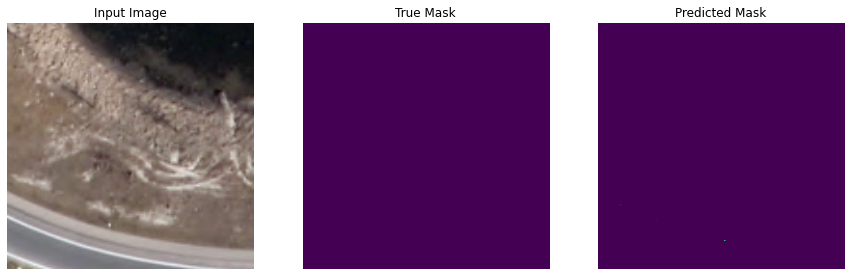

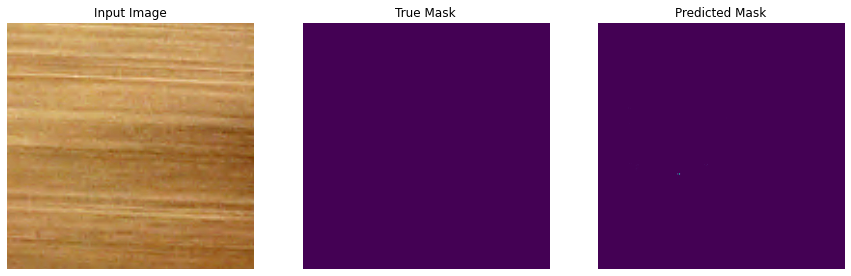

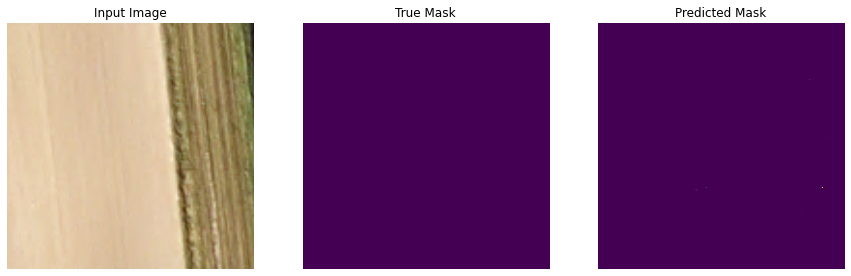

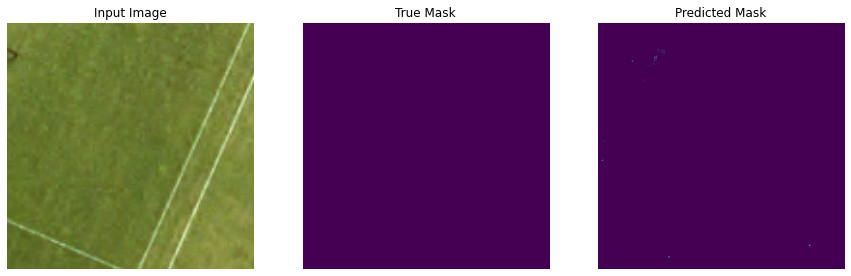

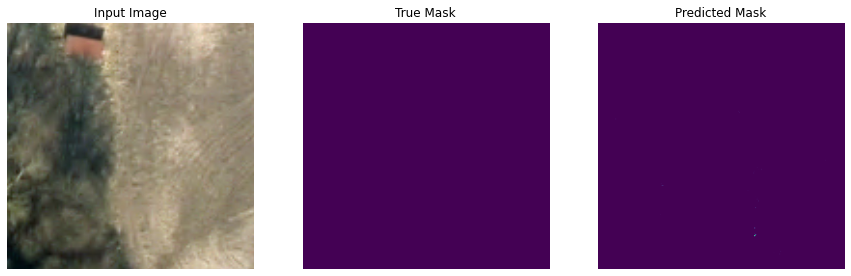

In [37]:
#inspecting results of predictions from validation images
for i in range(10,15):
    display([X[i],y[i],pred_mask[i]]).show()

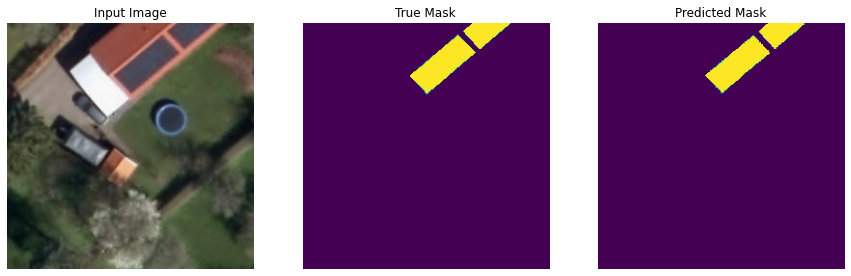

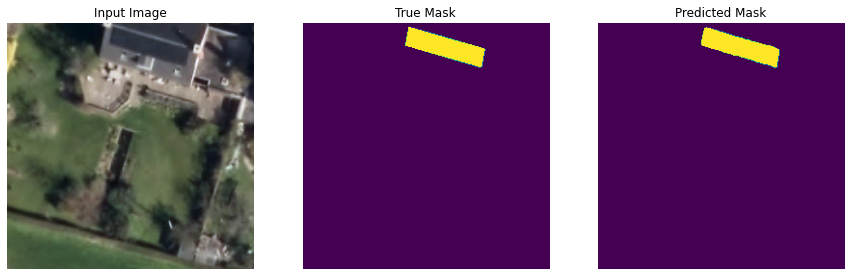

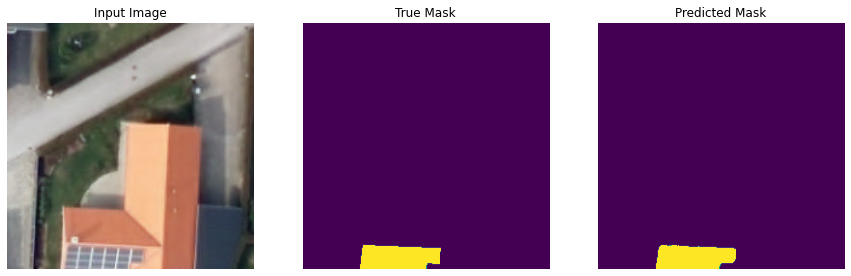

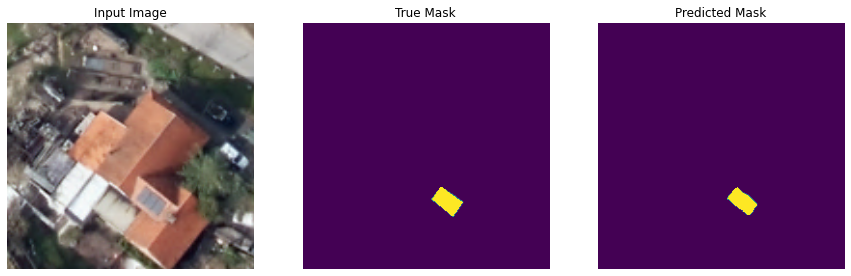

In [38]:
#prediction of the tensorboard images after training
show_predictions(0).show()
show_predictions(1).show()
show_predictions(2).show()
show_predictions(3).show()

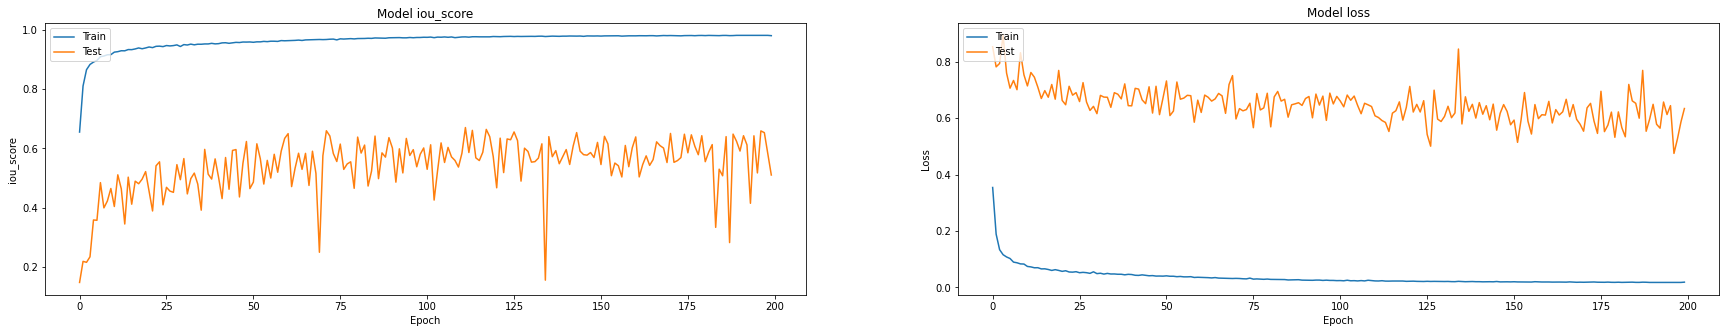

In [40]:
#Plot training & validation iou_score 0.5 values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history_base.history['IoUScoreThreshold05'])
plt.plot(history_base.history['val_IoUScoreThreshold05'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history_base.history['loss'])
plt.plot(history_base.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
# https://github.com/qubvel/segmentation_models/blob/master/examples/binary%20segmentation%20(camvid).ipynb